In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.utils import shuffle
import sklearn 
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

from sklearn import metrics
from sklearn.preprocessing import StandardScaler

import random
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt



In [2]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [3]:
from tqdm.auto import tqdm

In [33]:
def count(list_array, print_dist = True, ret = None):
    Total = list_array
    name = []
    for i in Total:
        name.append(i[:4])
    unique = []
    before_after = []
    for i in Total:
        if np.sum((np.array(name, dtype = int) == int(i[:4]))) == 1:
            unique.append(i)
        else:
            before_after.append(i) 

    Asthmatic_Female = []
    Asthmatic_Male = []
    Healthy_Male = []
    Healthy_Female = []
    NAsthma = {"male": [], "female": []}
    before = {"male" : [], "female" : []}
    after = {"male" : [], "female" : []}
    for file in unique:
        if file.split("_")[2] == 'Asthma' or file.split("_")[2] == 'asthma' :
            if file.find("_M_")!=-1:
                Asthmatic_Male.append(file)
            if file.find("_F_")!=-1:
                Asthmatic_Female.append(file)
        if file.split("_")[2] == 'NAsthma':
            if file.find("_M_") != -1:
                NAsthma["male"].append(file)
            else:
                NAsthma["female"].append(file)
                
        if file.find("_C_")!=-1:
            if file.find("_M_")!=-1:
                Healthy_Male.append(file)
            if file.find("_F_")!=-1:
                Healthy_Female.append(file)

    for file in before_after:
            if file.find("efore") != -1:
                if file.find("_M_") != -1 or file.find("_m_")!=-1:
                    before["male"].append(file)
                if file.find("_F_")!=-1:
                    before["female"].append(file)
            if file.find("fter")!= -1:
                if file.find("_M_") != -1 or file.find("_m_")!=-1:
                    after["male"].append(file)
                if file.find("_F_")!=-1:
                    after["female"].append(file)
    if print_dist:
        print(f"Total = {len(Total)}")
        print(f"Asthmatic_male = {len(Asthmatic_Male)+ len(before['male'])+len(after['male'])}")
        print(f"Asthmatic_female = {len(Asthmatic_Female)+ len(before['female'])+len(after['female'])}")
        print(f"Healthy_Male = {len(Healthy_Male)}")
        print(f"Healthy_female = {len(Healthy_Female)}")
        print(f"Asthmatic_male_unique = {len(Asthmatic_Male)}")
        print(f"Asthmatic_female_unique = {len(Asthmatic_Female)}")
        print(f"Before_after = {len(before_after)}")
        print(f"Before_male = {len(before['male'])}")
        print(f"Before_female = {len(before['female'])}")
        print(f"after_male = {len(after['male'])}")
        print(f"after_female = {len(after['female'])}")
        print(f"NAsthma Male = {len(NAsthma['male'])}")
        print(f"NAsthma Female = {len(NAsthma['female'])}")
        
              
    if ret != None:
        D = {"Total": Total, "Asthmatic_male": Asthmatic_Male, "Asthmatic_female": Asthmatic_Female, "Healthy_Male": Healthy_Male,
            "Healthy_Female": Healthy_Female, "before_after": before_after, "before": before, "after": after}
        return D[ret]

In [39]:
# Training and Testing
# C = shuffle(C, random_state= 22) 
def experiment(dataframe, path, svm_c = 1, svm_gamma = 'auto', plot = True, folds = 3):
    C = dataframe
    Test_accuracy = []
    Test_F1 = []
    Train_accuracy = []
    Train_F1 = []
    AUC = []

    FPR = []
    TPR = []
    THRESH = []

    for i in tqdm(range(0,folds)):
        Train_dataframe = pd.DataFrame()
        Test_dataframe = pd.DataFrame()
        Train = np.loadtxt(f"./Gender_classification/{path}/Train/train_{str(i)}.txt", 'str')
        Test = np.loadtxt(f"./Gender_classification/{path}/Test/test_{str(i)}.txt", 'str')

        for j in range(0,len(Train)):
            Train_dataframe = Train_dataframe.append(C[C.iloc[:,73] == Train[j]])

        for j in range(0,len(Test)):
            Test_dataframe = Test_dataframe.append(C[C.iloc[:,73] == Test[j]]) 


        Train_dataframe = shuffle(Train_dataframe, random_state= 42)

        scaler = StandardScaler()
        scaler.fit(C.iloc[:,:72])

        X_train = pd.DataFrame(scaler.transform(Train_dataframe.iloc[:,:72]))
        y_train = Train_dataframe.iloc[:,72]
        X_test = pd.DataFrame(scaler.transform(Test_dataframe.iloc[:,:72]))
        y_test = Test_dataframe.iloc[:,72]

        X_train.reset_index(drop=True, inplace= True)
        X_test.reset_index(drop=True, inplace= True)
        y_train.reset_index(drop=True, inplace= True)
        y_test.reset_index(drop=True, inplace= True)


        model = svm.SVC(C = svm_c,gamma=svm_gamma, probability=True)
        model.fit(X_train,y_train)

        Train_accuracy.append(metrics.accuracy_score(y_train, model.predict(X_train)))
        Test_accuracy.append(metrics.accuracy_score(y_test, model.predict(X_test)))

        Train_F1.append(metrics.f1_score(y_train, model.predict(X_train)))
        Test_F1.append(metrics.f1_score(y_test, model.predict(X_test))) 

        pred_prob = model.predict_proba(X_test)
        fpr, tpr, thresh = roc_curve(y_test, pred_prob[:,1], pos_label=1)
        auc_score = roc_auc_score(y_test, pred_prob[:,1])
        FPR.append(fpr)
        TPR.append(tpr)
        THRESH.append(thresh)
        AUC.append(auc_score)
    if plot == True:
        plt.style.use('seaborn')
        color = ['orange', 'green', 'yellow', 'black', 'red']
        for i in range(0, len(AUC)):
            plt.plot(FPR[i], TPR[i], linestyle='--',color=color[i], label=f'model_{str(i)}_AUC:{AUC[i]}')

        random_probs = [0 for i in range(len(y_test))]
        p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
        plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
        plt.title('ROC curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive rate')
        plt.legend(loc='best')
#         plt.savefig('ROC_Male_female_classification_',dpi=300)
        plt.show();

        print(f"Mean Test Accuracy:{np.mean(Test_accuracy)*100}% with SD: {np.std(Test_accuracy)*100}%")
        print(f"Mean Train Accuracy:{np.mean(Train_accuracy)*100}%")
        print(f"Mean Test F1:{np.mean(Test_F1)*100}% with SD: {np.std(Test_F1)*100}%")
        print(f"Mean Test AUC:{np.mean(AUC)*100}% with SD: {np.std(AUC)*100}%")
        
    return Train_accuracy, Test_accuracy, FPR, TPR, THRESH, AUC, Test_F1

### Enter the Sound Name

In [482]:
sound = "Zzz"

In [483]:
Data = pd.read_csv(f"./MFCC_csv_new_all/{sound}.csv")

In [484]:
Data.head()

,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
0,0.007349,-14.057344,20.921869,-12.183911,20.326073,-11.621114,-5.859119,-9.802375,-8.758561,-3.082370,...,21.876977,12.895054,8.988286,14.291325,11.993813,8.874162,21.754758,16.466552,1.0,4250_P_NAsthma_F_before_TBD_N.json
1,0.124495,-11.786404,18.113274,-10.730049,16.562490,-8.923441,-6.249891,-9.473049,-11.912596,0.035048,...,18.655554,12.712779,11.357564,12.740262,14.309725,7.915953,21.490569,16.201738,1.0,4250_P_NAsthma_F_before_TBD_N.json
2,0.327177,-10.564024,15.591213,-12.099323,16.050574,-7.609478,-6.844283,-9.587292,-11.497948,4.742951,...,19.064099,9.723270,10.374083,13.214596,14.011950,8.766319,21.481294,15.849013,1.0,4250_P_NAsthma_F_before_TBD_N.json
3,-0.264378,-12.460427,14.454387,-11.413801,11.545176,-12.273394,-8.183681,-10.053227,-12.100355,0.085441,...,15.382886,14.542305,12.675663,14.520366,14.676411,9.381174,22.376360,19.260545,1.0,4250_P_NAsthma_F_before_TBD_N.json
4,-0.266619,-11.789120,14.977073,-9.642930,10.424405,-11.233586,-7.061047,-7.939819,-11.198127,1.284005,...,14.839540,13.615932,11.669502,13.259168,15.334644,9.879185,17.411624,17.741597,1.0,4250_P_NAsthma_F_before_TBD_N.json


#### Astmatic Only

In [485]:
unique = np.unique(Data.iloc[:,73])
asthmatic = np.array([i for i in unique if i.find("sthma") != -1])
B = pd.DataFrame()
for i in asthmatic:
    B = B.append(Data[Data.iloc[:,73] == i])
B.iloc[:,72] = 1
B.reset_index(inplace=True,drop=True )

In [486]:
B.head()

,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
0,2.017061,-12.401052,31.969697,-1.561041,27.274009,1.761740,-2.739669,-0.921776,-4.285060,14.682730,...,28.157995,5.972515,7.015773,8.173132,7.860184,16.531080,6.640422,6.558926,1,4012_P_Asthma_F_after_Mil_Y.json
1,1.296472,-18.043225,30.226959,-1.119836,28.372871,0.490092,0.209755,2.190385,-3.392016,9.252388,...,29.077677,5.199171,6.309514,7.411672,7.271151,11.889224,7.939085,6.779715,1,4012_P_Asthma_F_after_Mil_Y.json
2,1.036210,-15.393092,32.456304,-3.296968,30.997294,0.453452,0.880520,2.197437,-5.059743,11.519033,...,32.000538,5.879721,6.427515,7.475171,7.838168,13.609946,6.732411,6.457111,1,4012_P_Asthma_F_after_Mil_Y.json
3,1.293108,-14.848246,31.823948,-0.357485,31.649548,0.415780,3.833195,1.690097,-4.190188,10.968163,...,32.427073,5.368979,7.898384,7.559574,7.469858,12.570446,7.424584,7.937549,1,4012_P_Asthma_F_after_Mil_Y.json
4,0.118397,-17.862816,27.647473,-2.690865,28.186654,-2.097703,2.201292,1.267637,-4.722846,7.050952,...,29.509962,6.639965,6.888833,6.757273,9.260991,9.796023,8.812095,6.448512,1,4012_P_Asthma_F_after_Mil_Y.json


In [487]:
count(list(np.unique(B.iloc[:,73])))

Total = 135
Asthmatic_male = 83
Asthmatic_female = 44
Healthy_Male = 0
Healthy_female = 0
Asthmatic_male_unique = 45
Asthmatic_female_unique = 18
Before_after = 64
Before_male = 19
Before_female = 13
after_male = 19
after_female = 13
NAsthma Male = 3
NAsthma Female = 5


In [488]:
#before only

C = pd.DataFrame()
before = [i for i in unique if i.find("efore") != -1]
for i in before:
    C = C.append(B[B.iloc[:,73] == i])
male = [i for i in before if i.find("_M_")!=-1]
female = [i for i in before if i.find("_F_")!=-1]

D = pd.DataFrame()
for i in female:
    D = D.append(C[C.iloc[:,73] == i])
D.iloc[:,72] = 0
for i in male:
    D= D.append(C[C.iloc[:,73] == i])
    
D.reset_index(drop=True, inplace=True)
shuffle(D).head()

,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,73
112,1.623920,-5.573700,9.838518,12.661623,7.500516,-0.744405,-6.287374,-20.930223,-0.227249,-0.936540,...,9.844028,7.310090,10.357536,23.171759,10.057559,8.082986,8.480811,8.906308,1,4139_P_Asthma_M_before_Sev_Y.json
31,0.005161,-21.178021,32.147311,-16.211242,24.554648,-19.159417,-14.433067,-16.114194,-1.642220,-9.841296,...,25.081499,20.259831,16.144726,17.138640,6.603639,11.447865,13.237050,17.357430,0,4405_P_Asthma_F_before_TBD_Y.json
118,1.443018,-8.189544,14.551522,21.137164,-5.277351,-15.817004,-17.745238,-19.249587,-2.690784,-11.711570,...,8.031074,17.671553,19.877812,23.505679,10.028506,14.331448,9.307575,8.279056,1,4172_P_Asthma_M_before_Mod_Y.json
183,-0.252749,-19.960401,19.267839,11.014300,6.505110,11.114900,-12.410825,-10.582975,11.078299,-0.405763,...,9.579150,13.505874,15.540985,14.588429,13.928079,7.012097,7.257927,7.712900,1,4503_P_NAsthma_M_before_TBD_Y.json
223,-2.735287,-18.351118,16.177642,22.504900,-17.600896,9.797652,21.754718,-24.796643,-7.339008,-1.001825,...,18.368731,11.661006,23.154178,26.695238,10.957622,7.581412,8.936991,6.933547,1,4758_P_Asthma_M_before_TBD_N.json


In [489]:
count(list(np.unique(D.iloc[:,73])))

Total = 51
Asthmatic_male = 31
Asthmatic_female = 16
Healthy_Male = 0
Healthy_female = 0
Asthmatic_male_unique = 31
Asthmatic_female_unique = 16
Before_after = 0
Before_male = 0
Before_female = 0
after_male = 0
after_female = 0
NAsthma Male = 1
NAsthma Female = 3


In [490]:
# sound = "Aaa"
exp = "before"
os.makedirs(f"./Gender_classification/{sound}/{exp}/Train",exist_ok=True)
os.makedirs(f"./Gender_classification/{sound}/{exp}/Test",exist_ok=True)
folds = 3
per_class = 5
Asthmatic_male = shuffle(count(list(np.unique(D.iloc[:,73])), print_dist=False, ret="Asthmatic_male"))
Asthmatic_female = shuffle(count(list(np.unique(D.iloc[:,73])), print_dist=False, ret="Asthmatic_female"))
for i in range(0,folds):
    Test = []
    Test.append(list(np.concatenate((Asthmatic_male[i*per_class:per_class+i*per_class],Asthmatic_female[i*per_class:per_class+i*per_class]))))
    Train = np.setdiff1d(before,Test)
    np.savetxt(f"./Gender_classification/{sound}/{exp}/Train/train_{str(i)}.txt", Train, '%s')
    np.savetxt(f"./Gender_classification/{sound}/{exp}/Test/test_{str(i)}.txt", Test[0], '%s')

  0%|          | 0/3 [00:00<?, ?it/s]

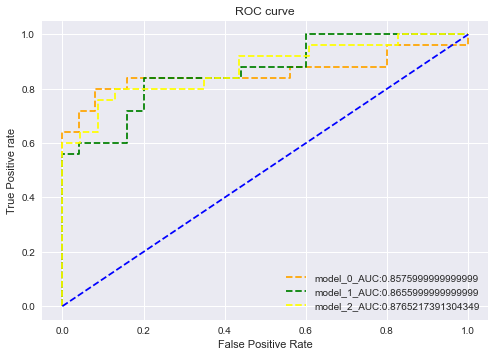

Mean Test Accuracy:76.33333333333333% with SD: 2.6246692913372724%
Mean Train Accuracy:99.66499162479062%
Mean Test F1:78.3035483035483% with SD: 1.8365985772577826%
Mean Test AUC:86.65739130434783% with SD: 0.775540383183455%


In [491]:
Train_accuracy, Test_accuracy, FPR, TPR, THRESH, AUC, Test_F1 = experiment(shuffle(D),f'/{sound}/{exp}', svm_c = 1, folds = 3)

In [492]:
#After patients

C = pd.DataFrame()
after = [i for i in unique if i.find("fter") != -1]
for i in after:
    C = C.append(B[B.iloc[:,73] == i])
male = [i for i in after if i.find("_M_")!=-1]
female = [i for i in after if i.find("_F_")!=-1]
D = pd.DataFrame()
for i in female:
    D = D.append(C[C.iloc[:,73] == i])
D.iloc[:,72] = 0
for i in male:
    D= D.append(C[C.iloc[:,73] == i])
    
count(list(np.unique(D.iloc[:,73])))

Total = 83
Asthmatic_male = 51
Asthmatic_female = 28
Healthy_Male = 0
Healthy_female = 0
Asthmatic_male_unique = 51
Asthmatic_female_unique = 28
Before_after = 0
Before_male = 0
Before_female = 0
after_male = 0
after_female = 0
NAsthma Male = 2
NAsthma Female = 2


In [493]:
exp = "after"
os.makedirs(f"./Gender_classification/{sound}/{exp}/Train",exist_ok=True)
os.makedirs(f"./Gender_classification/{sound}/{exp}/Test",exist_ok=True)
folds = 3
per_class = 10
male = shuffle(male)
female = shuffle(female)
for i in range(0,folds):
    Test = []
    Test.append(list(np.concatenate((male[i*per_class:per_class+i*per_class],female[i*per_class:per_class+i*per_class]))))
    Train = np.setdiff1d(after,Test)
    np.savetxt(f"./Gender_classification/{sound}/{exp}/Train/train_{str(i)}.txt", Train, '%s')
    np.savetxt(f"./Gender_classification/{sound}/{exp}/Test/test_{str(i)}.txt", Test[0], '%s')

  0%|          | 0/3 [00:00<?, ?it/s]

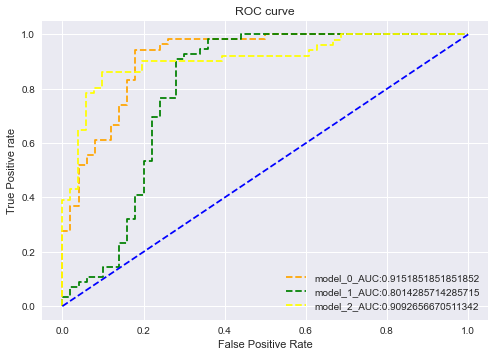

Mean Test Accuracy:77.84192777256041% with SD: 3.0533733803947403%
Mean Train Accuracy:96.56175534200555%
Mean Test F1:81.45017244745235% with SD: 2.6638974651476692%
Mean Test AUC:87.52931412216304% with SD: 5.2286015828135675%


In [494]:
Train_accuracy, Test_accuracy, FPR, TPR, THRESH, AUC, Test_F1 = experiment(shuffle(D),f'/{sound}/{exp}', svm_c = 1, folds = folds)

In [495]:
#all asthmatic
male = [i for i in (np.unique(B.iloc[:,73])) if i.find("_M_")!=-1]
female = [i for i in (np.unique(B.iloc[:,73])) if i.find("_F_")!=-1]

D = pd.DataFrame()
for i in female:
    D = D.append(B[B.iloc[:,73] == i])
D.iloc[:,72] = 0
for i in male:
    D= D.append(B[B.iloc[:,73] == i])
count(list(np.unique(D.iloc[:,73])))

Total = 135
Asthmatic_male = 83
Asthmatic_female = 44
Healthy_Male = 0
Healthy_female = 0
Asthmatic_male_unique = 45
Asthmatic_female_unique = 18
Before_after = 64
Before_male = 19
Before_female = 13
after_male = 19
after_female = 13
NAsthma Male = 3
NAsthma Female = 5


In [496]:
# sound = "Aaa"
exp = "All_asthmatic"
os.makedirs(f"./Gender_classification/{sound}/{exp}/Train",exist_ok=True)
os.makedirs(f"./Gender_classification/{sound}/{exp}/Test",exist_ok=True)
folds = 5
per_class = 12
male = shuffle(male)
female = shuffle(female)
for i in range(0,folds):
    Test = []
    Test.append(list(np.concatenate((male[i*per_class:per_class+i*per_class],female[i*per_class:per_class+i*per_class]))))
    Train = np.setdiff1d(list(np.unique(D.iloc[:,73])),Test)
    np.savetxt(f"./Gender_classification/{sound}/{exp}/Train/train_{str(i)}.txt", Train, '%s')
    np.savetxt(f"./Gender_classification/{sound}/{exp}/Test/test_{str(i)}.txt", Test[0], '%s')

  0%|          | 0/5 [00:00<?, ?it/s]

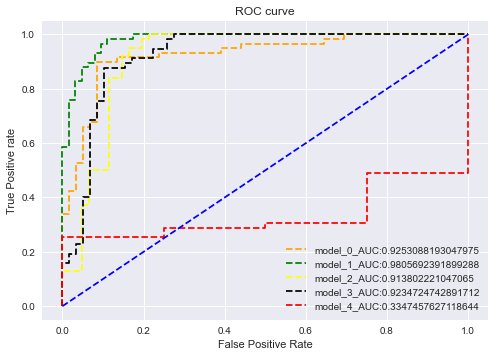

Mean Test Accuracy:87.33555337509215% with SD: 4.438416012786862%
Mean Train Accuracy:96.78442931469675%
Mean Test F1:89.03492540964825% with SD: 4.571545770014622%
Mean Test AUC:81.55797033085655% with SD: 24.155819890791427%


In [497]:
Train_accuracy, Test_accuracy, FPR, TPR, THRESH, AUC, Test_F1 = experiment(shuffle(D),f'/{sound}/{exp}', svm_c = 1, folds = 5)

In [498]:
#Healthy controls

unique = np.unique(Data.iloc[:,73])
controls = np.array([i for i in unique if i.find("_C_") != -1])
B = pd.DataFrame()
for i in controls:
    B = B.append(Data[Data.iloc[:,73] == i])
# B.iloc[:,72] = 1
B.reset_index(inplace=True,drop=True )

male = [i for i in (np.unique(B.iloc[:,73])) if i.find("_M_")!=-1]
female = [i for i in (np.unique(B.iloc[:,73])) if i.find("_F_")!=-1]

D = pd.DataFrame()
for i in male:
    D= D.append(B[B.iloc[:,73] == i])

D.iloc[:,72] = 1

for i in female:
    D = D.append(B[B.iloc[:,73] == i])
    
count(list(np.unique(D.iloc[:,73])))

Total = 95
Asthmatic_male = 0
Asthmatic_female = 0
Healthy_Male = 47
Healthy_female = 48
Asthmatic_male_unique = 0
Asthmatic_female_unique = 0
Before_after = 0
Before_male = 0
Before_female = 0
after_male = 0
after_female = 0
NAsthma Male = 0
NAsthma Female = 0


In [499]:
# sound = "Aaa"
exp = "Healthy"
os.makedirs(f"./Gender_classification/{sound}/{exp}/Train",exist_ok=True)
os.makedirs(f"./Gender_classification/{sound}/{exp}/Test",exist_ok=True)
folds = 5
per_class = 10
male = shuffle(male)
female = shuffle(female)
for i in range(0,folds):
    Test = []
    Test.append(list(np.concatenate((male[i*per_class:per_class+i*per_class],female[i*per_class:per_class+i*per_class]))))
    Train = np.setdiff1d(list(np.unique(D.iloc[:,73])),Test)
    np.savetxt(f"./Gender_classification/{sound}/{exp}/Train/train_{str(i)}.txt", Train, '%s')
    np.savetxt(f"./Gender_classification/{sound}/{exp}/Test/test_{str(i)}.txt", Test[0], '%s')

  0%|          | 0/5 [00:00<?, ?it/s]

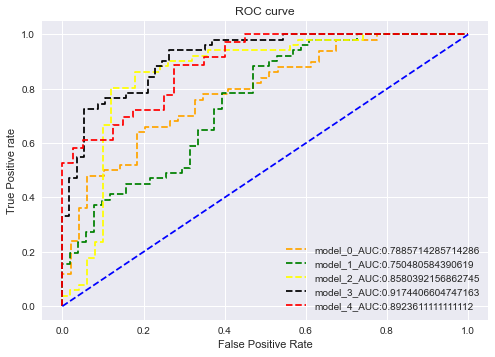

Mean Test Accuracy:75.1556610769436% with SD: 6.535949274210291%
Mean Train Accuracy:95.20309942638715%
Mean Test F1:74.68675355027239% with SD: 6.520823072658404%
Mean Test AUC:84.13786000468299% with SD: 6.27905664792244%


In [500]:
Train_accuracy, Test_accuracy, FPR, TPR, THRESH, AUC, Test_F1 = experiment(shuffle(D),f'/{sound}/{exp}', svm_c = .5, folds = 5)

In [501]:
#all_subjects
M1 = []
F1 = []

unique = np.unique(Data.iloc[:,73])
asthmatic = np.array([i for i in unique if i.find("sthma") != -1])
B = pd.DataFrame()
for i in asthmatic:
    B = B.append(Data[Data.iloc[:,73] == i])
B.iloc[:,72] = 1
B.reset_index(inplace=True,drop=True )
male = [i for i in (np.unique(B.iloc[:,73])) if i.find("_M_")!=-1]
female = [i for i in (np.unique(B.iloc[:,73])) if i.find("_F_")!=-1]

M1.extend(male)
F1.extend(female)

D1 = pd.DataFrame()
for i in female:
    D1 = D1.append(B[B.iloc[:,73] == i])
D1.iloc[:,72] = 0
for i in male:
    D1= D1.append(B[B.iloc[:,73] == i])

unique = np.unique(Data.iloc[:,73])
controls = np.array([i for i in unique if i.find("_C_") != -1])
B = pd.DataFrame()
for i in controls:
    B = B.append(Data[Data.iloc[:,73] == i])
# B.iloc[:,72] = 1
B.reset_index(inplace=True,drop=True )

male = [i for i in (np.unique(B.iloc[:,73])) if i.find("_M_")!=-1]
female = [i for i in (np.unique(B.iloc[:,73])) if i.find("_F_")!=-1]


M1.extend(male)
F1.extend(female)

D2 = pd.DataFrame()
for i in male:
    D2= D2.append(B[B.iloc[:,73] == i])

D2.iloc[:,72] = np.int(1)

for i in female:
    D2 = D2.append(B[B.iloc[:,73] == i])
D = shuffle(pd.concat([D1, D2]))

In [502]:
count(list(np.unique(D.iloc[:,73])))

Total = 230
Asthmatic_male = 83
Asthmatic_female = 44
Healthy_Male = 47
Healthy_female = 48
Asthmatic_male_unique = 45
Asthmatic_female_unique = 18
Before_after = 64
Before_male = 19
Before_female = 13
after_male = 19
after_female = 13
NAsthma Male = 3
NAsthma Female = 5


In [503]:
# sound = "Aaa"
exp = "All"
os.makedirs(f"./Gender_classification/{sound}/{exp}/Train",exist_ok=True)
os.makedirs(f"./Gender_classification/{sound}/{exp}/Test",exist_ok=True)
folds = 5
per_class = 20

# Asthmatic_male = shuffle(count(list(np.unique(D.iloc[:,73])), print_dist=False, ret="Asthmatic_male"))
# Asthmatic_female = shuffle(count(list(np.unique(D.iloc[:,73])), print_dist=False, ret="Asthmatic_female"))

# Healthy_Male = shuffle(count(list(np.unique(D.iloc[:,73])), print_dist=False, ret="Healthy_Male"))
# Healthy_Female = shuffle(count(list(np.unique(D.iloc[:,73])), print_dist=False, ret="Healthy_Female"))

male = shuffle(M1)
female = shuffle(F1)

for i in range(0,folds):
    Test = []
    Test.append(list(np.concatenate((male[i*per_class:per_class+i*per_class],female[i*per_class:per_class+i*per_class]))))
    Train = np.setdiff1d(list(np.unique(D.iloc[:,73])),Test)
    np.savetxt(f"./Gender_classification/{sound}/{exp}/Train/train_{str(i)}.txt", Train, '%s')
    np.savetxt(f"./Gender_classification/{sound}/{exp}/Test/test_{str(i)}.txt", Test[0], '%s')

  0%|          | 0/5 [00:00<?, ?it/s]

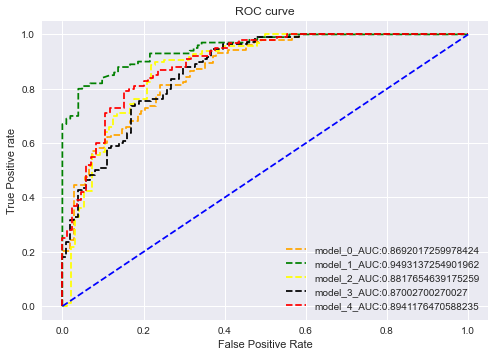

Mean Test Accuracy:80.49650078181794% with SD: 3.6574222479522156%
Mean Train Accuracy:96.58166798092849%
Mean Test F1:82.00109735739278% with SD: 3.2056366390791338%
Mean Test AUC:89.28851130329318% with SD: 2.964034436325208%


In [504]:
Train_accuracy, Test_accuracy, FPR, TPR, THRESH, AUC, Test_F1 = experiment(shuffle(D),f'/{sound}/{exp}', svm_c = 1, folds = 5)